In [55]:
import torch
from pathlib import Path
import yaml

from kvae.model.model import KVAE
from kvae.vae.config import KVAEConfig
from kvae.train.utils import parse_device, build_dataloaders
from kvae.train.train import evaluate
from kvae.train.imputation import impute_epoch, impute_batch


def load_checkpoint(checkpoint_path, device='auto'):
    """
    Load a trained KVAE model from checkpoint.
    
    Args:
        checkpoint_path: Path to checkpoint file (.pt)
        device: Device to load model on ('auto', 'cuda', 'cpu', 'mps')
    
    Returns:
        model: Loaded KVAE model
        checkpoint: Full checkpoint dictionary with training info
        device: The actual device being used
    """
    checkpoint_path = Path(checkpoint_path)
    if not checkpoint_path.exists():
        raise FileNotFoundError(f"Checkpoint not found: {checkpoint_path}")
    
    device = parse_device(device)
    
    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    # Initialize model with config
    cfg = KVAEConfig()
    model = KVAE(cfg).to(device)
    
    # Load weights
    model.load_state_dict(checkpoint['model_state'])
    model.eval()
    
    print(f"✓ Loaded checkpoint from epoch {checkpoint['epoch']}")
    print(f"  Train loss: {checkpoint['train_loss']:.6f}")
    print(f"  Val loss: {checkpoint['val_loss']:.6f}")
    
    return model, checkpoint, device


# Example usage:
# runs/20251204-214705
# runs/20251212-201237
# runs/20251212-205425
# runs/20251212-214826
runs_path = Path("../runs/20251212-214826")
checkpoint_path = runs_path / "checkpoints/kvae-best.pt"

model, ckpt, device = load_checkpoint(checkpoint_path, device='cpu')
print(f"\nModel loaded on: {device}")


✓ Loaded checkpoint from epoch 28
  Train loss: 4.998628
  Val loss: 4.527907

Model loaded on: cpu


# KVAE Model Evaluation

Load a trained checkpoint and run inference/evaluation.

In [56]:
# Load config from the run directory
config_path = runs_path / "config.yaml"

with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

print("Configuration:")
for key, value in config.items():
    print(f"  {key}: {value}")


Configuration:
  dataset: {'kwargs': {'load_in_memory': True, 'normalize': False, 'seq_len': 20}, 'num_workers': 6, 'path': '/Users/rodrigopaganini/master/data/pgm/kvae/box.npz', 'type': 'pymunk', 'val_split': 0.2}
  training: {'add_imputation_plots': True, 'batch_size': 32, 'ckpt_every': 5, 'device': 'mps', 'gpus': 1, 'logdir': 'runs', 'lr': 0.007, 'max_epochs': 100, 'pretrain_vae_epochs': 0, 'seed': 10, 'warmup_epochs': 5}
  transforms: {'add_noise_std': 0.0}


In [57]:
# Load data
train_loader, val_loader = build_dataloaders(
    config['dataset'], 
    batch_size=config['training']['batch_size']
)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Using device: {device}")


Train batches: 125
Val batches: 32
Using device: cpu


## Evaluate on validation set

In [58]:
# Manual evaluation loop - collect detailed outputs for visualization
model.eval()

# Get one batch for detailed analysis
sample_batch = next(iter(val_loader))
x = sample_batch["images"].float().to(device)
B, T = x.shape[:2]

# 1. Full reconstruction (no masking)
with torch.no_grad():
    model.kalman_filter.dyn_params.reset_state()
    mask = torch.ones(B, T, device=device, dtype=x.dtype)
    
    outputs = model(x, mask=mask)
    losses = model.compute_loss(x, outputs, kf_weight=1.0, mask=mask)
    imp_outs = impute_epoch(model, val_loader, device=device)  # to reset any internal states if needed
    
print("Full Reconstruction Outputs:")
print(f"  Loss: {losses['loss']:.6f}")
print(f"  ELBO VAE: {losses['elbo_vae_total']:.6f}")
print(f"  ELBO KF: {losses['elbo_kf']:.6f}")
print(f"\nAvailable outputs: {list(outputs.keys())}")
print(f"  x_recon shape: {outputs['x_recon'].shape}")
print(f"  a_samples shape: {outputs['a_samples'].shape}")
print(f"  mus_smooth shape: {outputs['mus_smooth'].shape}")
print(f"  mus_filt shape: {outputs['mus_filt'].shape}")



/Users/rodrigopaganini/master/code/pgm/kalman-vae/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Full Reconstruction Outputs:
  Loss: 4.461289
  ELBO VAE: -2.329676
  ELBO KF: -2.131614

Available outputs: ['x_recon', 'x_logits', 'a_samples', 'a_mu', 'a_var', 'mus_smooth', 'Sigmas_smooth', 'mus_filt', 'Sigmas_filt', 'mus_pred', 'Sigmas_pred', 'ABC', 'u']
  x_recon shape: torch.Size([32, 20, 1, 32, 32])
  a_samples shape: torch.Size([32, 20, 2])
  mus_smooth shape: torch.Size([32, 20, 4, 1])
  mus_filt shape: torch.Size([32, 20, 4, 1])


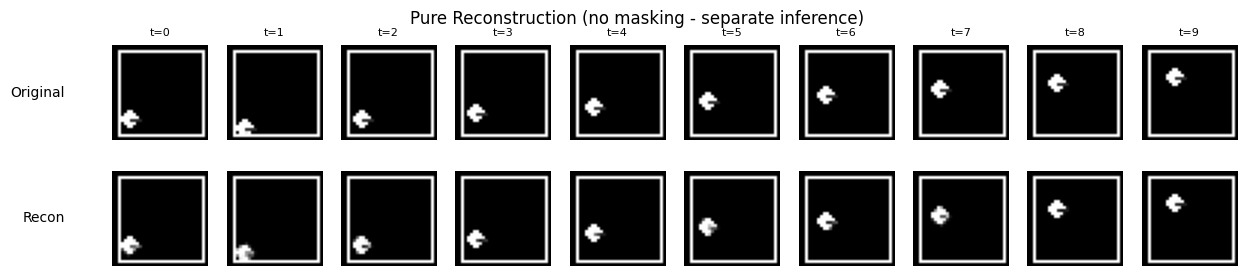

In [59]:
import matplotlib.pyplot as plt
import numpy as np

# Run pure reconstruction WITHOUT any masking (separate from imputation)
idx = 0
n_frames = min(10, T)

# Run full reconstruction (all frames observed, no masking)
with torch.no_grad():
    model.kalman_filter.dyn_params.reset_state()
    mask_full = torch.ones(B, T, device=device)
    recon_outputs = model(x, mask=mask_full)

fig, axes = plt.subplots(2, n_frames, figsize=(n_frames*1.5, 3))
for t in range(n_frames):
    # Original
    axes[0, t].imshow(x[idx, t].cpu().squeeze(), cmap='gray')
    axes[0, t].axis('off')
    axes[0, t].set_title(f't={t}', fontsize=8)
    
    # Pure reconstruction (no masking applied)
    axes[1, t].imshow(recon_outputs['x_recon'][idx, t].cpu().squeeze(), cmap='gray')
    axes[1, t].axis('off')

fig.subplots_adjust(left=0.15)
axes[0, 0].text(-0.5, 0.5, 'Original', transform=axes[0, 0].transAxes, fontsize=10, ha='right', va='center')
axes[1, 0].text(-0.5, 0.5, 'Recon', transform=axes[1, 0].transAxes, fontsize=10, ha='right', va='center')
plt.suptitle('Pure Reconstruction (no masking - separate inference)', fontsize=12)
plt.show()


In [60]:
# Manual evaluation loop - collect detailed outputs for visualization
model.eval()

# Get one batch for detailed analysis
sample_batch = next(iter(val_loader))
x = sample_batch["images"].float().to(device)
B, T = x.shape[:2]
n_frames = T
t_obs = 4
idx = 0

# 1. Full reconstruction (no masking)
with torch.no_grad():
    model.kalman_filter.dyn_params.reset_state()
    mask = torch.ones(B, T, device=device, dtype=x.dtype)
    mask[:, t_obs:] = 0  # Mask last half of the sequence
    imp_outputs = impute_batch(model, sample_batch, mask=mask, device=device)  # to reset any internal states if needed
    
print("Full Reconstruction Outputs:")
print(f"  Loss: {losses['loss']:.6f}")
print(f"  ELBO VAE: {losses['elbo_vae_total']:.6f}")
print(f"  ELBO KF: {losses['elbo_kf']:.6f}")
print(f"\nAvailable outputs: {list(imp_outputs.keys())}")
print(f"  x_recon shape: {imp_outputs['x_recon'].shape}")
print(f"  x_imputed shape: {imp_outputs['x_imputed'].shape}")



Full Reconstruction Outputs:
  Loss: 4.461289
  ELBO VAE: -2.329676
  ELBO KF: -2.131614

Available outputs: ['x_real', 'x_recon', 'x_imputed', 'x_filtered', 'mse_smooth', 'mse_filt', 'mse_recon', 'baseline']
  x_recon shape: torch.Size([32, 20, 1, 32, 32])
  x_imputed shape: torch.Size([32, 20, 1, 32, 32])


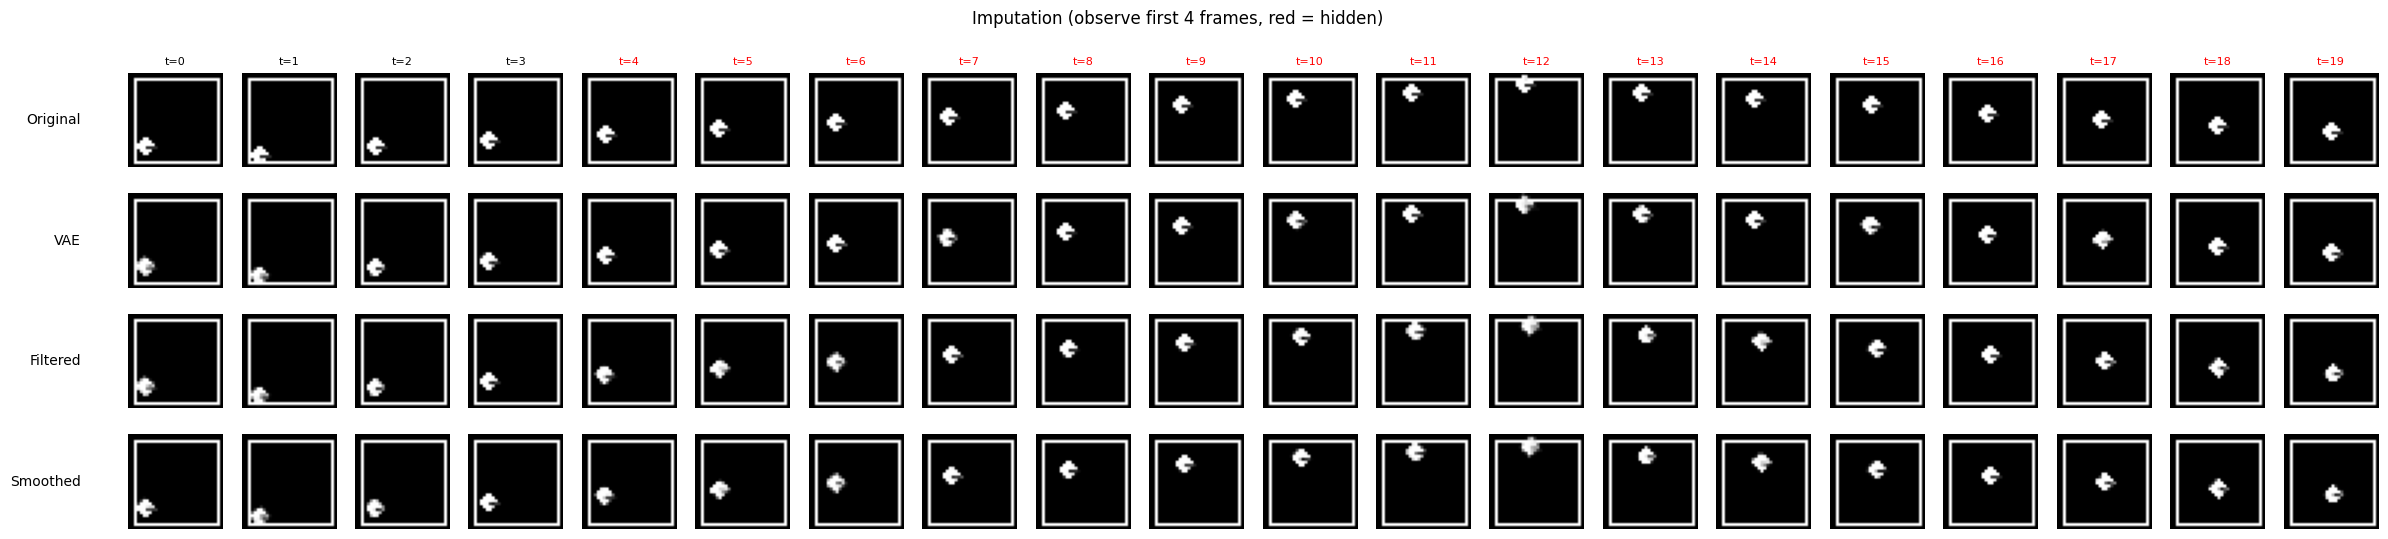

In [61]:
# Visualize imputation results
fig, axes = plt.subplots(4, n_frames, figsize=(n_frames*1.5, 6))
for t in range(n_frames):
    is_observed = t < t_obs
    
    # Original
    axes[0, t].imshow(x[idx, t].cpu().squeeze(), cmap='gray')
    axes[0, t].axis('off')
    if not is_observed:
        axes[0, t].set_title(f't={t}', fontsize=8, color='red')
    else:
        axes[0, t].set_title(f't={t}', fontsize=8)
    
    # VAE Reconstruction (baseline)
    axes[1, t].imshow(imp_outputs['x_recon'][idx, t].cpu().squeeze(), cmap='gray')
    axes[1, t].axis('off')
    
    # Filtered (online - causal)
    axes[2, t].imshow(imp_outputs['x_filtered'][idx, t].cpu().squeeze(), cmap='gray')
    axes[2, t].axis('off')
    
    # Smoothed (offline - non-causal)
    axes[3, t].imshow(imp_outputs['x_imputed'][idx, t].cpu().squeeze(), cmap='gray')
    axes[3, t].axis('off')

fig.subplots_adjust(left=0.15)
axes[0, 0].text(-0.5, 0.5, 'Original', transform=axes[0, 0].transAxes, fontsize=10, ha='right', va='center')
axes[1, 0].text(-0.5, 0.5, 'VAE', transform=axes[1, 0].transAxes, fontsize=10, ha='right', va='center')
axes[2, 0].text(-0.5, 0.5, 'Filtered', transform=axes[2, 0].transAxes, fontsize=10, ha='right', va='center')
axes[3, 0].text(-0.5, 0.5, 'Smoothed', transform=axes[3, 0].transAxes, fontsize=10, ha='right', va='center')
plt.suptitle(f'Imputation (observe first {t_obs} frames, red = hidden)', fontsize=12)
plt.show()


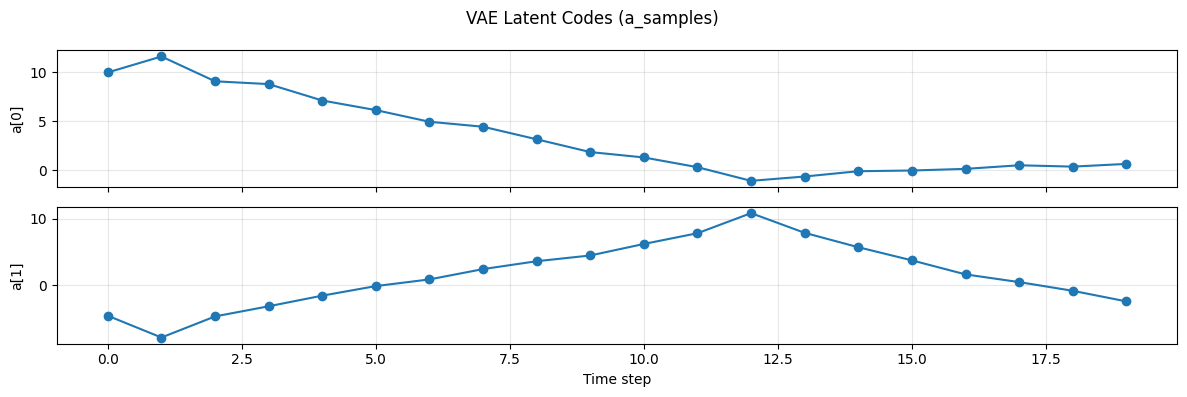

In [62]:
# Plot VAE latent codes (a_samples)
a_vae = outputs['a_samples'][idx].cpu().numpy()  # [T, a_dim]
a_dim = a_vae.shape[1]

fig, axes = plt.subplots(min(4, a_dim), 1, figsize=(12, min(4, a_dim)*2), sharex=True)
if a_dim == 1:
    axes = [axes]

for i in range(min(4, a_dim)):
    axes[i].plot(a_vae[:, i], marker='o', label=f'a[{i}]')
    axes[i].set_ylabel(f'a[{i}]', fontsize=10)
    axes[i].grid(True, alpha=0.3)
    
axes[-1].set_xlabel('Time step', fontsize=10)
plt.suptitle('VAE Latent Codes (a_samples)', fontsize=12)
plt.tight_layout()
plt.show()


## Test Imputation

In [63]:
# 2. Imputation (observe first 4 frames, predict rest)
t_obs = 4
mask_imp = torch.ones(B, T, device=device)
mask_imp[:, t_obs:] = 0.0  # Hide frames after t_obs

with torch.no_grad():
    model.kalman_filter.dyn_params.reset_state()
    imp_outputs = model.impute(x, mask=mask_imp)

print(f"\nImputation Outputs (observe first {t_obs} frames):")
print(f"Available outputs: {list(imp_outputs.keys())}")
print(f"  x_recon shape: {imp_outputs['x_recon'].shape}")
print(f"  x_imputed shape: {imp_outputs['x_imputed'].shape}")
print(f"  x_filtered shape: {imp_outputs['x_filtered'].shape}")
print(f"  a_vae shape: {imp_outputs['a_vae'].shape}")
print(f"  a_imputed shape: {imp_outputs['a_imputed'].shape}")
print(f"  a_filtered shape: {imp_outputs['a_filtered'].shape}")

# Compute MSE on hidden frames
unobs = mask_imp < 0.5
unobs_px = unobs.view(B, T, 1, 1, 1)

def mse_on_unobs(x_hat):
    diff2 = (x - x_hat) ** 2
    mask_full = unobs_px.expand_as(x)
    diff2 = diff2[mask_full.bool()]
    return diff2.mean().item()

print(f"\nMSE on hidden frames:")
print(f"  VAE baseline: {mse_on_unobs(imp_outputs['x_recon']):.6e}")
print(f"  Filtered (online): {mse_on_unobs(imp_outputs['x_filtered']):.6e}")
print(f"  Smoothed (offline): {mse_on_unobs(imp_outputs['x_imputed']):.6e}")



Imputation Outputs (observe first 4 frames):
Available outputs: ['x_recon', 'x_imputed', 'x_filtered', 'a_vae', 'a_imputed', 'a_filtered']
  x_recon shape: torch.Size([32, 20, 1, 32, 32])
  x_imputed shape: torch.Size([32, 20, 1, 32, 32])
  x_filtered shape: torch.Size([32, 20, 1, 32, 32])
  a_vae shape: torch.Size([32, 20, 2])
  a_imputed shape: torch.Size([32, 20, 2])
  a_filtered shape: torch.Size([32, 20, 2])

MSE on hidden frames:
  VAE baseline: 6.328779e-04
  Filtered (online): 2.453267e-02
  Smoothed (offline): 2.453267e-02


## Visualize Reconstruction and Imputation

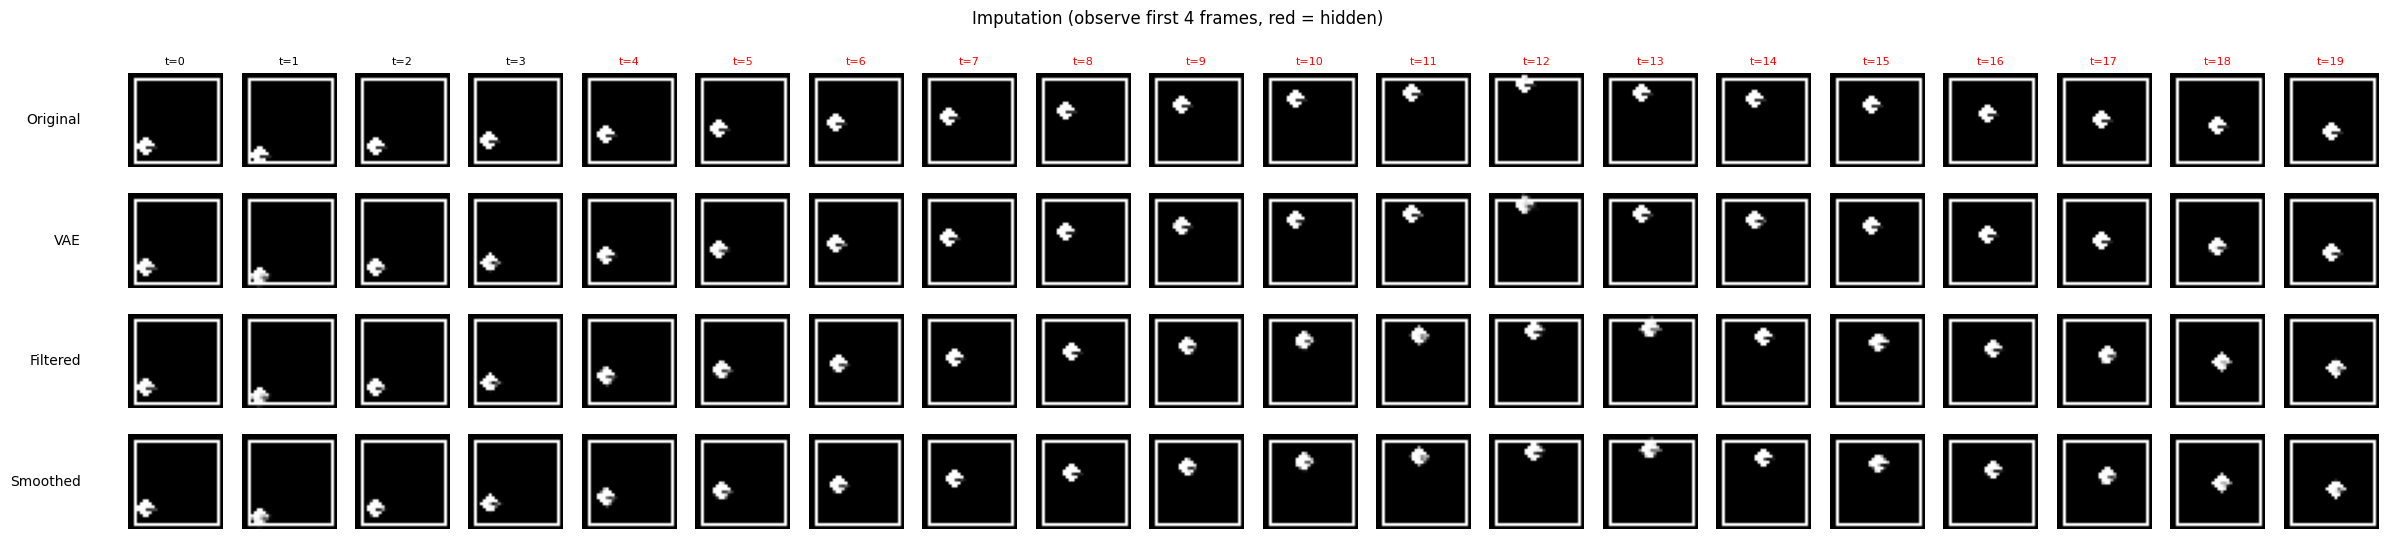

In [64]:
# Visualize imputation results
fig, axes = plt.subplots(4, n_frames, figsize=(n_frames*1.5, 6))
for t in range(n_frames):
    is_observed = t < t_obs
    
    # Original
    axes[0, t].imshow(x[idx, t].cpu().squeeze(), cmap='gray')
    axes[0, t].axis('off')
    if not is_observed:
        axes[0, t].set_title(f't={t}', fontsize=8, color='red')
    else:
        axes[0, t].set_title(f't={t}', fontsize=8)
    
    # VAE Reconstruction (baseline)
    axes[1, t].imshow(imp_outputs['x_recon'][idx, t].cpu().squeeze(), cmap='gray')
    axes[1, t].axis('off')
    
    # Filtered (online - causal)
    axes[2, t].imshow(imp_outputs['x_filtered'][idx, t].cpu().squeeze(), cmap='gray')
    axes[2, t].axis('off')
    
    # Smoothed (offline - non-causal)
    axes[3, t].imshow(imp_outputs['x_imputed'][idx, t].cpu().squeeze(), cmap='gray')
    axes[3, t].axis('off')

fig.subplots_adjust(left=0.15)
axes[0, 0].text(-0.5, 0.5, 'Original', transform=axes[0, 0].transAxes, fontsize=10, ha='right', va='center')
axes[1, 0].text(-0.5, 0.5, 'VAE', transform=axes[1, 0].transAxes, fontsize=10, ha='right', va='center')
axes[2, 0].text(-0.5, 0.5, 'Filtered', transform=axes[2, 0].transAxes, fontsize=10, ha='right', va='center')
axes[3, 0].text(-0.5, 0.5, 'Smoothed', transform=axes[3, 0].transAxes, fontsize=10, ha='right', va='center')
plt.suptitle(f'Imputation (observe first {t_obs} frames, red = hidden)', fontsize=12)
plt.show()


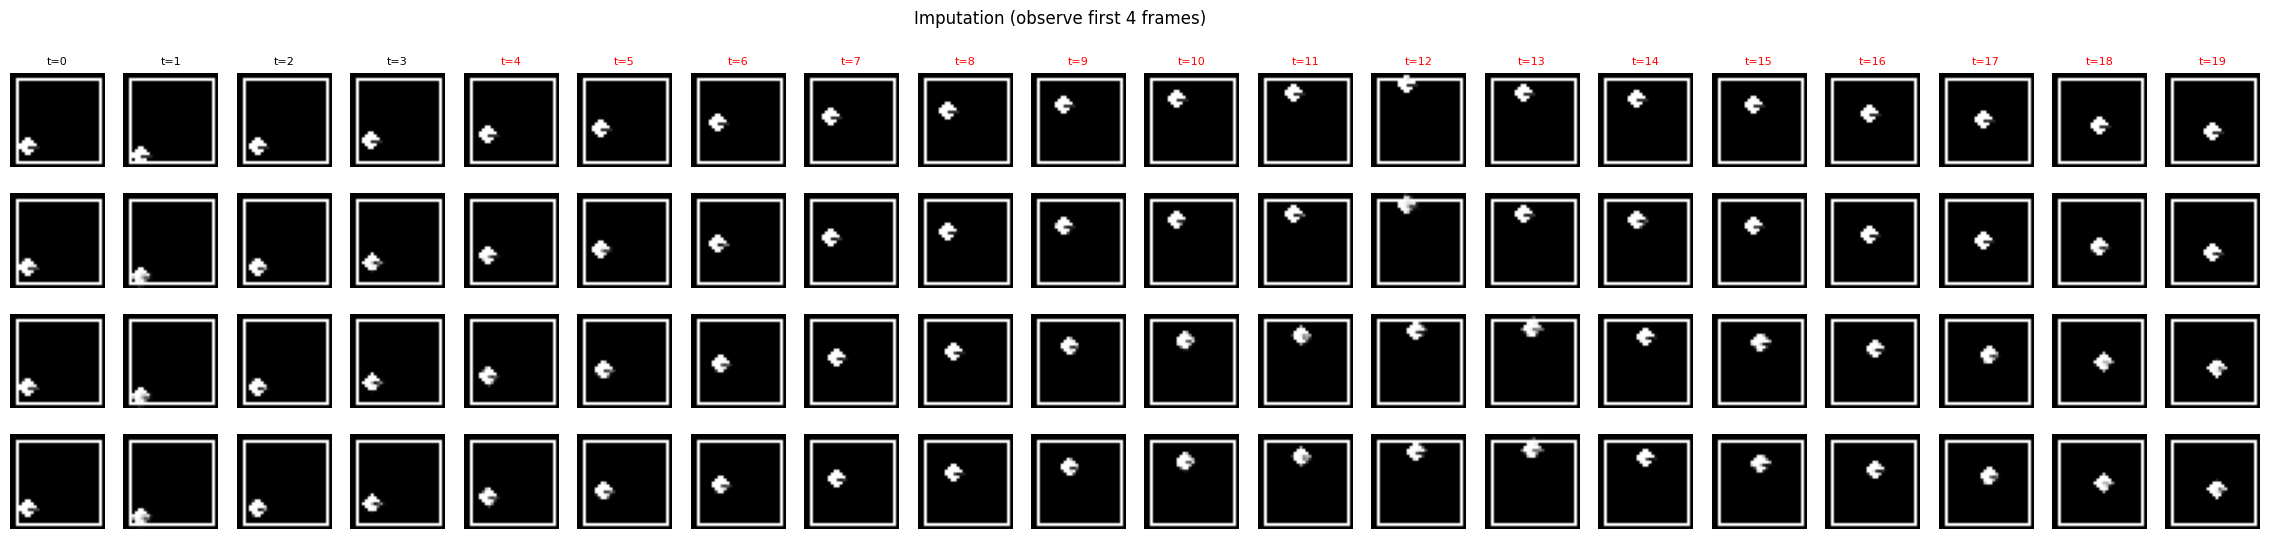

In [65]:
# Visualize imputation results
fig, axes = plt.subplots(4, n_frames, figsize=(n_frames*1.5, 6))
for t in range(n_frames):
    is_observed = t < t_obs
    
    # Original
    axes[0, t].imshow(x[idx, t].cpu().squeeze(), cmap='gray')
    axes[0, t].axis('off')
    if not is_observed:
        axes[0, t].set_title(f't={t}', fontsize=8, color='red')
    else:
        axes[0, t].set_title(f't={t}', fontsize=8)
    
    # VAE Reconstruction (baseline)
    axes[1, t].imshow(imp_outputs['x_recon'][idx, t].cpu().squeeze(), cmap='gray')
    axes[1, t].axis('off')
    
    # Filtered (online - causal)
    axes[2, t].imshow(imp_outputs['x_filtered'][idx, t].cpu().squeeze(), cmap='gray')
    axes[2, t].axis('off')
    
    # Smoothed (offline - non-causal)
    axes[3, t].imshow(imp_outputs['x_imputed'][idx, t].cpu().squeeze(), cmap='gray')
    axes[3, t].axis('off')

fig.subplots_adjust(left=0.15)
axes[0, 0].set_ylabel('')
axes[1, 0].set_ylabel('')
axes[2, 0].set_ylabel('')
axes[3, 0].set_ylabel('')

axes[0, 0].set_ylabel('Original', transform=axes[0, 0].transAxes, fontsize=10, ha='right', va='center')
axes[1, 0].set_ylabel('VAE', transform=axes[1, 0].transAxes, fontsize=10, ha='right', va='center')
axes[2, 0].set_ylabel('Filtered', transform=axes[2, 0].transAxes, fontsize=10, ha='right', va='center')
axes[3, 0].set_ylabel('Smoothed', transform=axes[3, 0].transAxes, fontsize=10, ha='right', va='center')
plt.suptitle(f'Imputation (observe first {t_obs} frames)', fontsize=12)
# plt.tight_layout()
plt.show()


## Visualize Latent Space

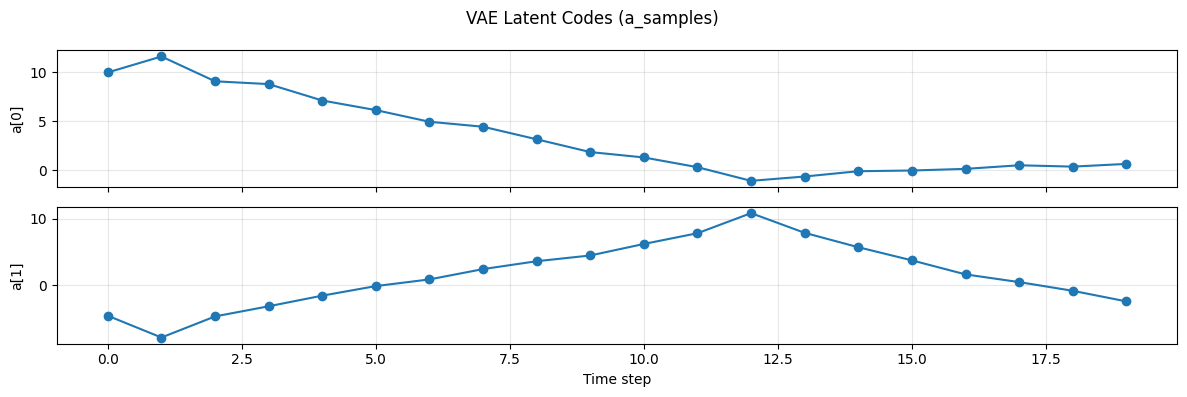

In [66]:
# Plot VAE latent codes (a_samples)
a_vae = outputs['a_samples'][idx].cpu().numpy()  # [T, a_dim]
a_dim = a_vae.shape[1]

fig, axes = plt.subplots(min(4, a_dim), 1, figsize=(12, min(4, a_dim)*2), sharex=True)
if a_dim == 1:
    axes = [axes]

for i in range(min(4, a_dim)):
    axes[i].plot(a_vae[:, i], marker='o', label=f'a[{i}]')
    axes[i].set_ylabel(f'a[{i}]', fontsize=10)
    axes[i].grid(True, alpha=0.3)

axes[-1].set_xlabel('Time step', fontsize=10)
plt.suptitle('VAE Latent Codes (a_samples)', fontsize=12)
plt.tight_layout()
plt.show()


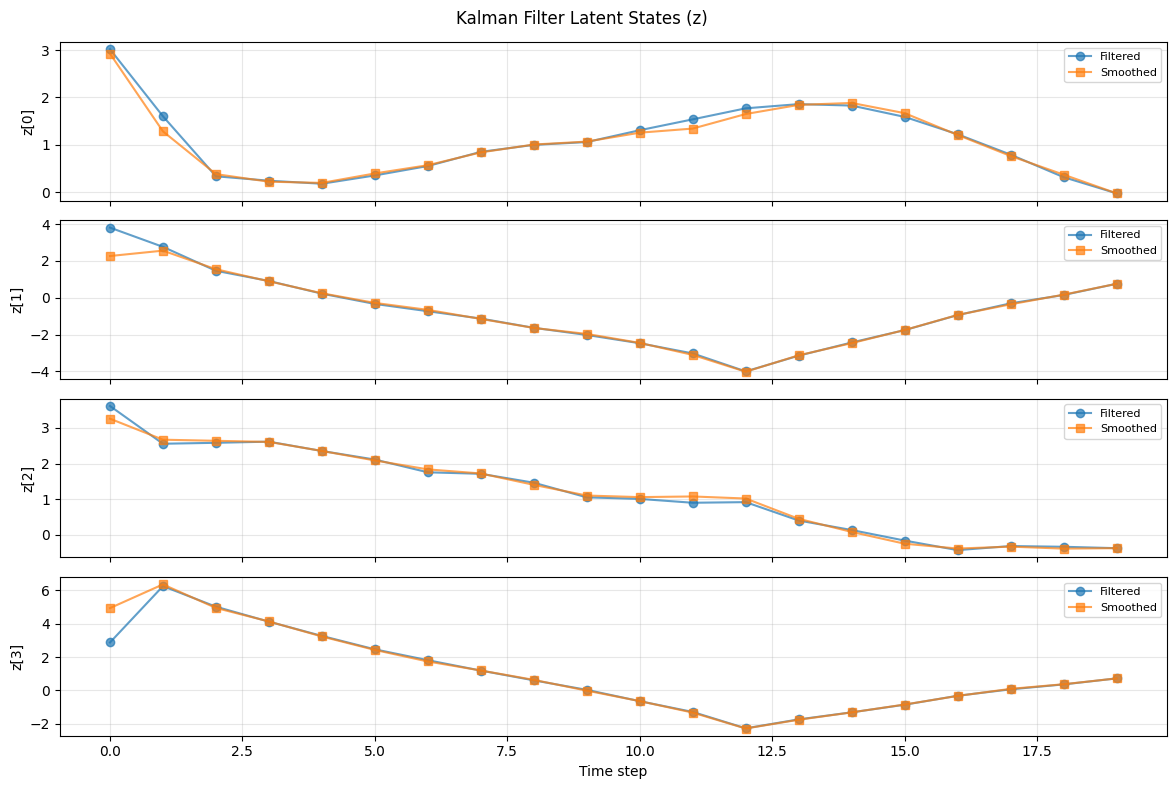

In [67]:
# Plot Kalman filter latent states (z)
mus_smooth = outputs['mus_smooth'][idx].cpu().squeeze(-1).numpy()  # [T, z_dim]
mus_filt = outputs['mus_filt'][idx].cpu().squeeze(-1).numpy()      # [T, z_dim]
z_dim = mus_smooth.shape[1]

fig, axes = plt.subplots(min(4, z_dim), 1, figsize=(12, min(4, z_dim)*2), sharex=True)
if z_dim == 1:
    axes = [axes]

for i in range(min(4, z_dim)):
    axes[i].plot(mus_filt[:, i], marker='o', label='Filtered', alpha=0.7)
    axes[i].plot(mus_smooth[:, i], marker='s', label='Smoothed', alpha=0.7)
    axes[i].set_ylabel(f'z[{i}]', fontsize=10)
    axes[i].legend(loc='upper right', fontsize=8)
    axes[i].grid(True, alpha=0.3)
    
axes[-1].set_xlabel('Time step', fontsize=10)
plt.suptitle('Kalman Filter Latent States (z)', fontsize=12)
plt.tight_layout()
plt.show()


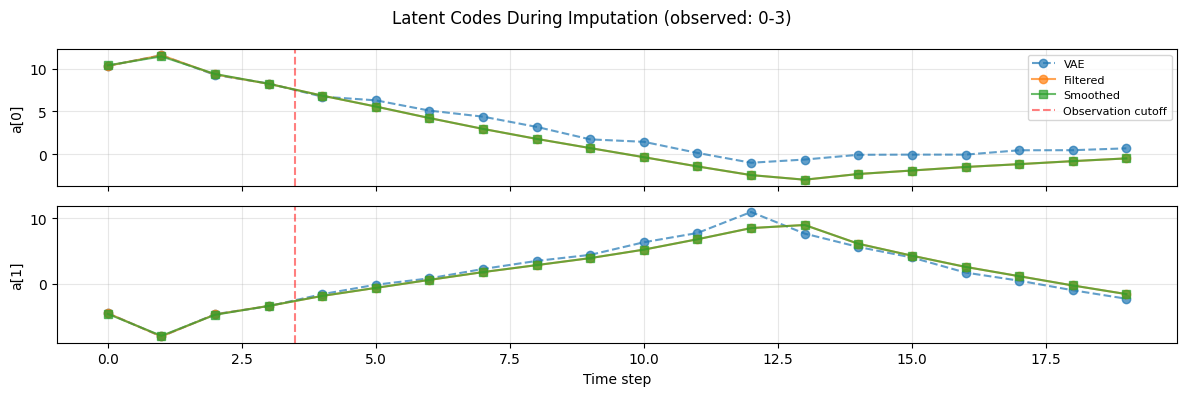

In [68]:
# Compare latent codes during imputation
a_vae_imp = imp_outputs['a_vae'][idx].cpu().numpy()           # VAE encoding
a_filt_imp = imp_outputs['a_filtered'][idx].cpu().numpy()     # From filtered z
a_smooth_imp = imp_outputs['a_imputed'][idx].cpu().numpy()    # From smoothed z

fig, axes = plt.subplots(min(4, a_dim), 1, figsize=(12, min(4, a_dim)*2), sharex=True)
if a_dim == 1:
    axes = [axes]

for i in range(min(4, a_dim)):
    axes[i].plot(a_vae_imp[:, i], marker='o', label='VAE', alpha=0.7, linestyle='--')
    axes[i].plot(a_filt_imp[:, i], marker='o', label='Filtered', alpha=0.7)
    axes[i].plot(a_smooth_imp[:, i], marker='s', label='Smoothed', alpha=0.7)
    axes[i].axvline(x=t_obs-0.5, color='red', linestyle='--', alpha=0.5, label='Observation cutoff')
    axes[i].set_ylabel(f'a[{i}]', fontsize=10)
    if i == 0:
        axes[i].legend(loc='upper right', fontsize=8)
    axes[i].grid(True, alpha=0.3)
    
axes[-1].set_xlabel('Time step', fontsize=10)
plt.suptitle(f'Latent Codes During Imputation (observed: 0-{t_obs-1})', fontsize=12)
plt.tight_layout()
plt.show()


## Iterate Through Multiple Samples

In [69]:
# Process multiple batches and store results
results = []
n_batches = 3
assert n_batches <= 4, "Careful with batch size and memory usage!"

val_iter = iter(val_loader)
for batch_idx in range(min(n_batches, len(val_loader))):
    batch = next(val_iter)
    x = batch["images"].float().to(device)
    B, T = x.shape[:2]
    
    with torch.no_grad():
        # Full reconstruction
        model.kalman_filter.dyn_params.reset_state()
        mask = torch.ones(B, T, device=device)
        out = model(x, mask=mask)
        
        # Imputation
        model.kalman_filter.dyn_params.reset_state()
        mask_imp = torch.ones(B, T, device=device)
        mask_imp[:, t_obs:] = 0.0
        imp_out = model.impute(x, mask=mask_imp)
        
        results.append({
            'batch_idx': batch_idx,
            'x': x.cpu(),
            'reconstruction': out['x_recon'].cpu(),
            'a_vae': out['a_samples'].cpu(),
            'z_smooth': out['mus_smooth'].cpu(),
            'z_filt': out['mus_filt'].cpu(),
            'imputation': {
                'x_recon': imp_out['x_recon'].cpu(),
                'x_filtered': imp_out['x_filtered'].cpu(),
                'x_imputed': imp_out['x_imputed'].cpu(),
                'a_vae': imp_out['a_vae'].cpu(),
                'a_filtered': imp_out['a_filtered'].cpu(),
                'a_imputed': imp_out['a_imputed'].cpu(),
            }
        })

print(f"Processed {len(results)} batches")
print(f"Each batch has {results[0]['x'].shape[0]} sequences")


Processed 3 batches
Each batch has 32 sequences


In [70]:
len(results)

3

In [71]:
# Interactive: choose which sample to visualize
batch_idx = 1  # Which batch
seq_idx = 0    # Which sequence within batch

data = results[batch_idx]
x_sample = data['x'][seq_idx]
x_recon = data['reconstruction'][seq_idx]
a_vae = data['a_vae'][seq_idx]

# Imputation data
imp = data['imputation']
x_imp_recon = imp['x_recon'][seq_idx]
x_imp_filt = imp['x_filtered'][seq_idx]
x_imp_smooth = imp['x_imputed'][seq_idx]
a_imp_vae = imp['a_vae'][seq_idx]
a_imp_filt = imp['a_filtered'][seq_idx]
a_imp_smooth = imp['a_imputed'][seq_idx]

print(f"Visualizing batch {batch_idx}, sequence {seq_idx}")
print(f"Frames: {x_sample.shape[0]}, Image size: {x_sample.shape[1:]}")


Visualizing batch 1, sequence 0
Frames: 20, Image size: torch.Size([1, 32, 32])


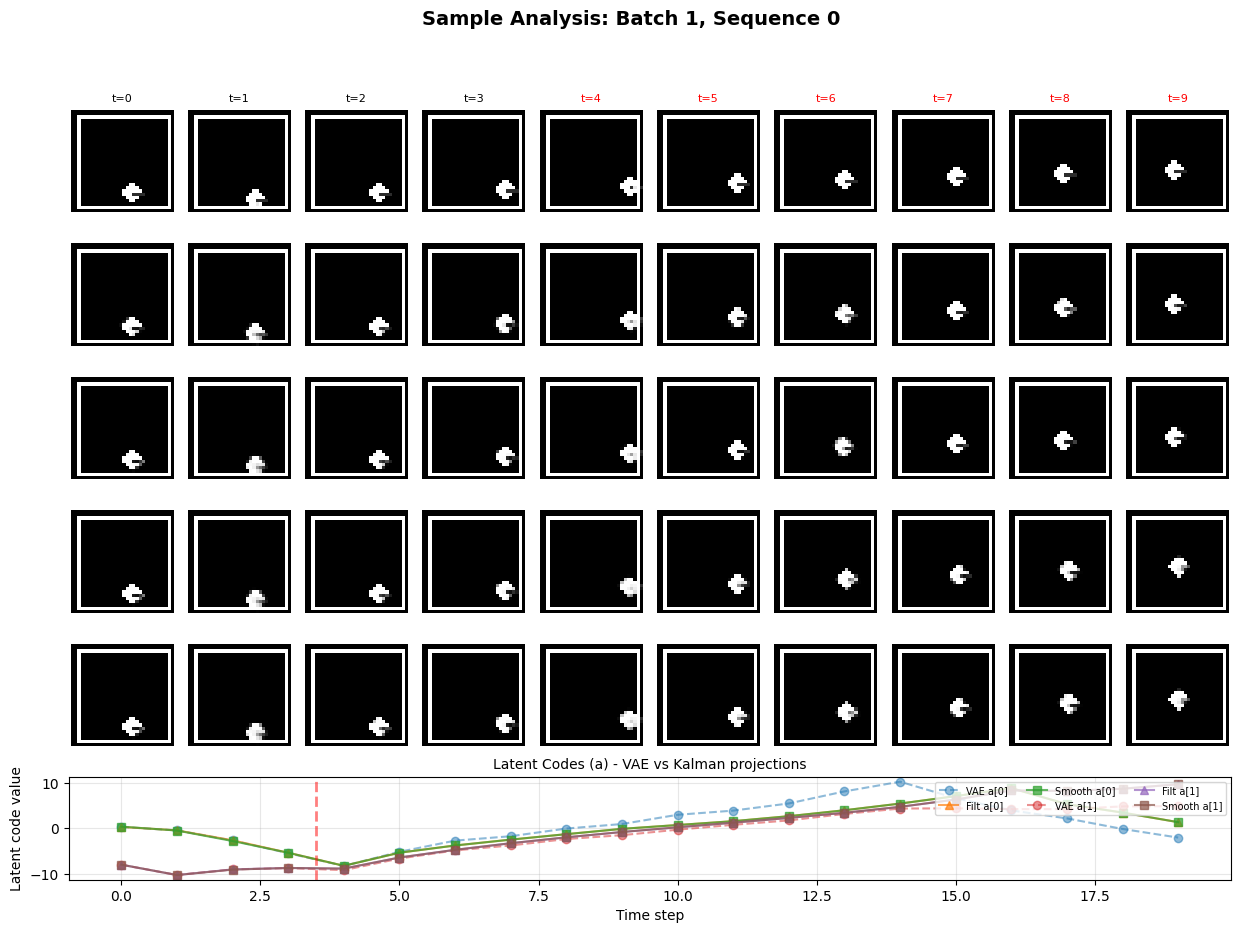

In [72]:
# Comprehensive visualization for selected sample
n_frames = min(10, x_sample.shape[0])

fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(6, n_frames, hspace=0.3, wspace=0.1)

# Row 1-4: Images
for t in range(n_frames):
    is_observed = t < t_obs
    
    # Original
    ax = fig.add_subplot(gs[0, t])
    ax.imshow(x_sample[t].squeeze(), cmap='gray')
    ax.axis('off')
    if t == 0:
        ax.set_ylabel('Original', fontsize=9)
    ax.set_title(f't={t}', fontsize=8, color='red' if not is_observed else 'black')
    
    # Reconstruction
    ax = fig.add_subplot(gs[1, t])
    ax.imshow(x_recon[t].squeeze(), cmap='gray')
    ax.axis('off')
    if t == 0:
        ax.set_ylabel('Recon', fontsize=9)
    
    # Imputation: VAE
    ax = fig.add_subplot(gs[2, t])
    ax.imshow(x_imp_recon[t].squeeze(), cmap='gray')
    ax.axis('off')
    if t == 0:
        ax.set_ylabel('Imp:VAE', fontsize=9)
    
    # Imputation: Filtered
    ax = fig.add_subplot(gs[3, t])
    ax.imshow(x_imp_filt[t].squeeze(), cmap='gray')
    ax.axis('off')
    if t == 0:
        ax.set_ylabel('Imp:Filt', fontsize=9)
    
    # Imputation: Smoothed
    ax = fig.add_subplot(gs[4, t])
    ax.imshow(x_imp_smooth[t].squeeze(), cmap='gray')
    ax.axis('off')
    if t == 0:
        ax.set_ylabel('Imp:Smooth', fontsize=9)

# Row 5-6: Latent codes
ax_a = fig.add_subplot(gs[5, :])
a_dim_plot = min(3, a_vae.shape[1])
for i in range(a_dim_plot):
    ax_a.plot(a_imp_vae[:, i].numpy(), marker='o', label=f'VAE a[{i}]', alpha=0.5, linestyle='--')
    ax_a.plot(a_imp_filt[:, i].numpy(), marker='^', label=f'Filt a[{i}]', alpha=0.7)
    ax_a.plot(a_imp_smooth[:, i].numpy(), marker='s', label=f'Smooth a[{i}]', alpha=0.7)
ax_a.axvline(x=t_obs-0.5, color='red', linestyle='--', alpha=0.5, linewidth=2)
ax_a.set_xlabel('Time step')
ax_a.set_ylabel('Latent code value')
ax_a.legend(ncol=3, fontsize=7, loc='upper right')
ax_a.grid(True, alpha=0.3)
ax_a.set_title('Latent Codes (a) - VAE vs Kalman projections', fontsize=10)

plt.suptitle(f'Sample Analysis: Batch {batch_idx}, Sequence {seq_idx}', fontsize=14, fontweight='bold')
plt.show()


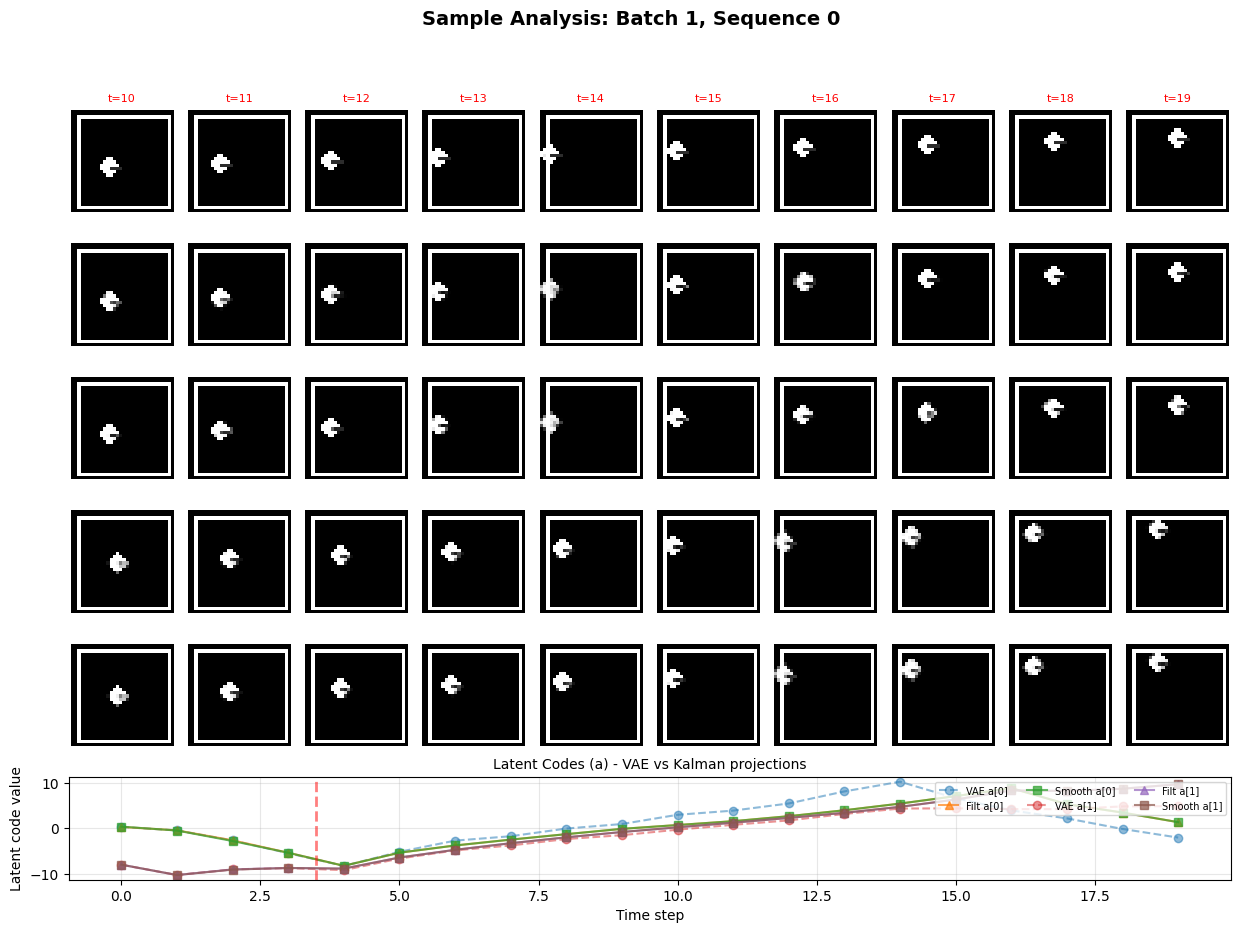

In [73]:
# Comprehensive visualization for selected sample
n_frames = min(10, x_sample.shape[0])

fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(6, n_frames, hspace=0.3, wspace=0.1)

# Row 1-4: Images
for t in range(10, x_sample.shape[0]):
    is_observed = t < t_obs
    
    # Original
    ax = fig.add_subplot(gs[0, t - 10])
    ax.imshow(x_sample[t].squeeze(), cmap='gray')
    ax.axis('off')
    if t == 0:
        ax.set_ylabel('Original', fontsize=9)
    ax.set_title(f't={t}', fontsize=8, color='red' if not is_observed else 'black')
    
    # Reconstruction
    ax = fig.add_subplot(gs[1, t - 10])
    ax.imshow(x_recon[t].squeeze(), cmap='gray')
    ax.axis('off')
    if t == 0:
        ax.set_ylabel('Recon', fontsize=9)
    
    # Imputation: VAE
    ax = fig.add_subplot(gs[2, t - 10])
    ax.imshow(x_imp_recon[t].squeeze(), cmap='gray')
    ax.axis('off')
    if t == 0:
        ax.set_ylabel('Imp:VAE', fontsize=9)
    
    # Imputation: Filtered
    ax = fig.add_subplot(gs[3, t - 10])
    ax.imshow(x_imp_filt[t].squeeze(), cmap='gray')
    ax.axis('off')
    if t == 0:
        ax.set_ylabel('Imp:Filt', fontsize=9)
    
    # Imputation: Smoothed
    ax = fig.add_subplot(gs[4, t - 10])
    ax.imshow(x_imp_smooth[t].squeeze(), cmap='gray')
    ax.axis('off')
    if t == 0:
        ax.set_ylabel('Imp:Smooth', fontsize=9)

# Row 5-6: Latent codes
ax_a = fig.add_subplot(gs[5, :])
a_dim_plot = min(3, a_vae.shape[1])
for i in range(a_dim_plot):
    ax_a.plot(a_imp_vae[:, i].numpy(), marker='o', label=f'VAE a[{i}]', alpha=0.5, linestyle='--')
    ax_a.plot(a_imp_filt[:, i].numpy(), marker='^', label=f'Filt a[{i}]', alpha=0.7)
    ax_a.plot(a_imp_smooth[:, i].numpy(), marker='s', label=f'Smooth a[{i}]', alpha=0.7)
ax_a.axvline(x=t_obs-0.5, color='red', linestyle='--', alpha=0.5, linewidth=2)
ax_a.set_xlabel('Time step')
ax_a.set_ylabel('Latent code value')
ax_a.legend(ncol=3, fontsize=7, loc='upper right')
ax_a.grid(True, alpha=0.3)
ax_a.set_title('Latent Codes (a) - VAE vs Kalman projections', fontsize=10)

plt.suptitle(f'Sample Analysis: Batch {batch_idx}, Sequence {seq_idx}', fontsize=14, fontweight='bold')
plt.show()

## Dynamics Parameter Evolution

Analyze the softmax weights over time to see if they saturate to specific states.

In [74]:
# Extract softmax weights during forward pass
# We need to modify the forward pass to collect alpha weights

# Check number of dynamics modes
K = model.kalman_filter.dyn_params.K
print(f"Number of dynamics modes (K): {K}")

if K == 1:
    print("Only 1 dynamics mode - no softmax switching behavior to visualize")
else:
    # Run forward pass and collect softmax weights
    model.eval()
    
    # Get a sample batch
    sample_batch = next(iter(val_loader))
    x = sample_batch["images"].float().to(device)
    B, T = x.shape[:2]
    
    # Store softmax weights at each timestep
    alpha_weights = []
    
    # Monkey-patch to collect weights
    original_compute_step = model.kalman_filter.dyn_params.compute_step
    
    def compute_step_with_logging(a_tprev):
        batch = a_tprev.size(0)
        
        if model.kalman_filter.dyn_params.K == 1:
            return original_compute_step(a_tprev)
        
        a_tprev_expanded = a_tprev.unsqueeze(1)
        h, new_state = model.kalman_filter.dyn_params.lstm(
            a_tprev_expanded, 
            model.kalman_filter.dyn_params.lstm_state
        )
        model.kalman_filter.dyn_params.lstm_state = new_state
        
        alpha_logits = model.kalman_filter.dyn_params.head_w(h.squeeze(1))
        w = torch.softmax(alpha_logits, dim=-1)
        
        # Store weights
        alpha_weights.append(w.detach().cpu())
        
        A = torch.einsum('bk,kij->bij', w, model.kalman_filter.dyn_params.A)
        B = torch.einsum('bk,knm->bnm', w, model.kalman_filter.dyn_params.B)
        C = torch.einsum('bk,kpn->bpn', w, model.kalman_filter.dyn_params.C)
        
        return A, B, C
    
    # Temporarily replace method
    model.kalman_filter.dyn_params.compute_step = compute_step_with_logging
    
    with torch.no_grad():
        model.kalman_filter.dyn_params.reset_state()
        mask = torch.ones(B, T, device=device)
        outputs = model(x, mask=mask)
    
    # Restore original method
    model.kalman_filter.dyn_params.compute_step = original_compute_step
    
    # Stack collected weights: [T, B, K]
    alpha_weights = torch.stack(alpha_weights, dim=0)
    print(f"\nCollected softmax weights shape: {alpha_weights.shape} (T, B, K)")
    print(f"Number of timesteps: {alpha_weights.shape[0]}")
    print(f"Batch size: {alpha_weights.shape[1]}")
    print(f"Number of modes: {alpha_weights.shape[2]}")

Number of dynamics modes (K): 3

Collected softmax weights shape: torch.Size([21, 32, 3]) (T, B, K)
Number of timesteps: 21
Batch size: 32
Number of modes: 3

Collected softmax weights shape: torch.Size([21, 32, 3]) (T, B, K)
Number of timesteps: 21
Batch size: 32
Number of modes: 3


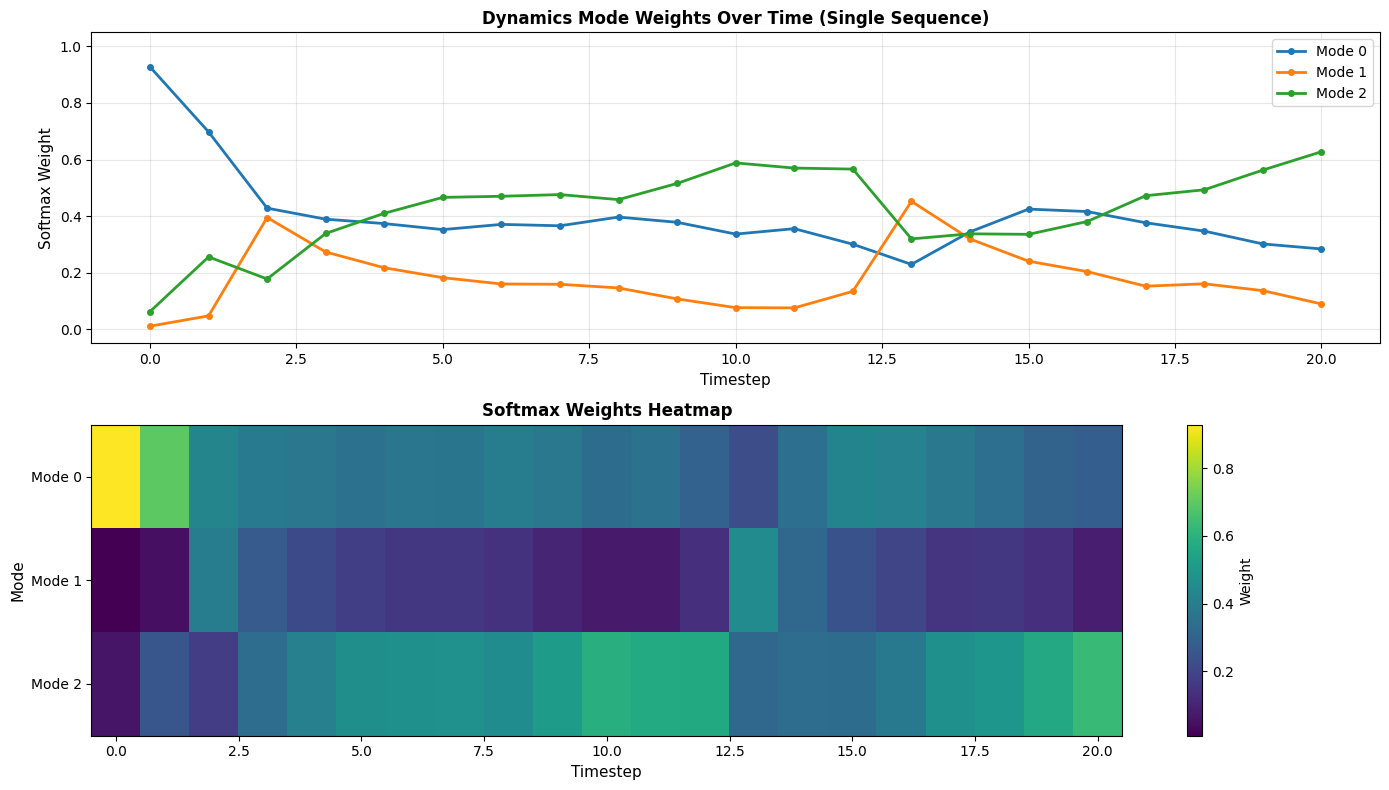


=== Softmax Statistics for Sequence 0 ===

Mode 0:
  Mean: 0.3996
  Std:  0.1463
  Min:  0.2289
  Max:  0.9278
  Times > 0.9: 1/21
  Times > 0.5: 2/21

Mode 1:
  Mean: 0.1776
  Std:  0.1075
  Min:  0.0104
  Max:  0.4520
  Times > 0.9: 0/21
  Times > 0.5: 0/21

Mode 2:
  Mean: 0.4228
  Std:  0.1394
  Min:  0.0618
  Max:  0.6275
  Times > 0.9: 0/21
  Times > 0.5: 6/21

=== Saturation Analysis ===
Dominant mode switches: 4 times out of 20 transitions
Timesteps per mode:
  Mode 0: 7/21 timesteps (33.3%)
  Mode 1: 1/21 timesteps (4.8%)
  Mode 2: 13/21 timesteps (61.9%)


In [75]:
# Plot softmax evolution for a single sequence
if K > 1:
    seq_idx = 0  # Choose which sequence to visualize
    
    # Get softmax weights for this sequence: [T, K]
    weights_seq = alpha_weights[:, seq_idx, :].numpy()
    T_actual, K_actual = weights_seq.shape
    
    # Create visualization
    fig, axes = plt.subplots(2, 1, figsize=(14, 8))
    
    # Plot 1: Line plot of each mode's weight over time
    ax1 = axes[0]
    for k in range(K_actual):
        ax1.plot(weights_seq[:, k], marker='o', label=f'Mode {k}', linewidth=2, markersize=4)
    ax1.set_xlabel('Timestep', fontsize=11)
    ax1.set_ylabel('Softmax Weight', fontsize=11)
    ax1.set_title('Dynamics Mode Weights Over Time (Single Sequence)', fontsize=12, fontweight='bold')
    ax1.legend(loc='best', fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(-0.05, 1.05)
    
    # Plot 2: Heatmap
    ax2 = axes[1]
    im = ax2.imshow(weights_seq.T, aspect='auto', cmap='viridis', interpolation='nearest')
    ax2.set_xlabel('Timestep', fontsize=11)
    ax2.set_ylabel('Mode', fontsize=11)
    ax2.set_title('Softmax Weights Heatmap', fontsize=12, fontweight='bold')
    ax2.set_yticks(range(K_actual))
    ax2.set_yticklabels([f'Mode {k}' for k in range(K_actual)])
    plt.colorbar(im, ax=ax2, label='Weight')
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\n=== Softmax Statistics for Sequence {seq_idx} ===")
    for k in range(K_actual):
        mode_weights = weights_seq[:, k]
        print(f"\nMode {k}:")
        print(f"  Mean: {mode_weights.mean():.4f}")
        print(f"  Std:  {mode_weights.std():.4f}")
        print(f"  Min:  {mode_weights.min():.4f}")
        print(f"  Max:  {mode_weights.max():.4f}")
        print(f"  Times > 0.9: {(mode_weights > 0.9).sum()}/{T_actual}")
        print(f"  Times > 0.5: {(mode_weights > 0.5).sum()}/{T_actual}")
    
    # Check if weights saturate to one mode
    dominant_mode = weights_seq.argmax(axis=1)
    mode_changes = (dominant_mode[1:] != dominant_mode[:-1]).sum()
    print(f"\n=== Saturation Analysis ===")
    print(f"Dominant mode switches: {mode_changes} times out of {T_actual-1} transitions")
    
    from collections import Counter
    mode_counts = Counter(dominant_mode)
    print(f"Timesteps per mode:")
    for mode, count in sorted(mode_counts.items()):
        print(f"  Mode {mode}: {count}/{T_actual} timesteps ({100*count/T_actual:.1f}%)")

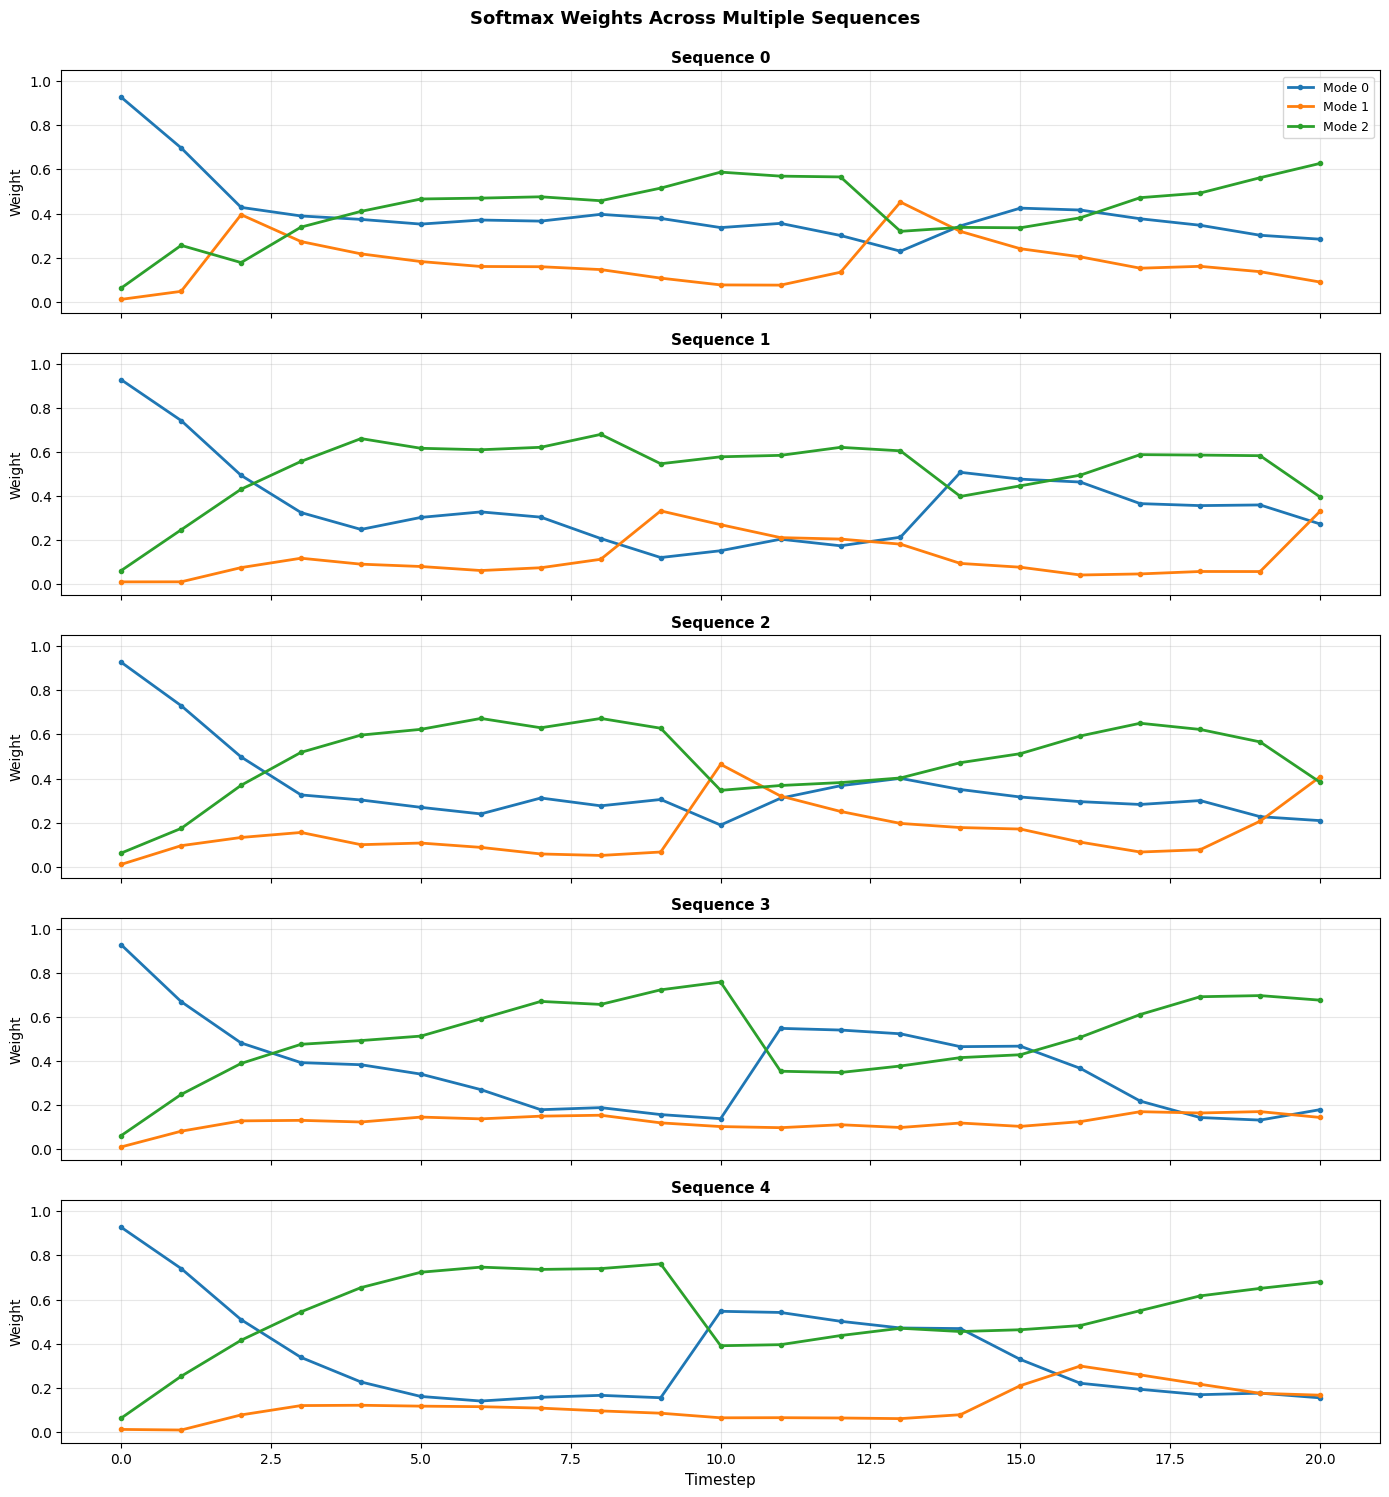


=== Cross-Sequence Analysis ===
Seq 0: Mode 2 dominates 13/21 steps (62%)
Seq 1: Mode 2 dominates 16/21 steps (76%)
Seq 2: Mode 2 dominates 16/21 steps (76%)
Seq 3: Mode 2 dominates 13/21 steps (62%)
Seq 4: Mode 2 dominates 13/21 steps (62%)
Seq 5: Mode 2 dominates 18/21 steps (86%)
Seq 6: Mode 2 dominates 13/21 steps (62%)
Seq 7: Mode 2 dominates 16/21 steps (76%)
Seq 8: Mode 0 dominates 12/21 steps (57%)
Seq 9: Mode 0 dominates 10/21 steps (48%)


In [76]:
# Plot multiple sequences to see consistency across batch
if K > 1:
    n_seqs_to_plot = min(5, B)
    
    fig, axes = plt.subplots(n_seqs_to_plot, 1, figsize=(14, 3*n_seqs_to_plot), sharex=True, sharey=True)
    if n_seqs_to_plot == 1:
        axes = [axes]
    
    for seq_idx in range(n_seqs_to_plot):
        ax = axes[seq_idx]
        weights_seq = alpha_weights[:, seq_idx, :].numpy()
        
        for k in range(K):
            ax.plot(weights_seq[:, k], marker='o', label=f'Mode {k}', linewidth=2, markersize=3)
        
        ax.set_ylabel('Weight', fontsize=10)
        ax.set_title(f'Sequence {seq_idx}', fontsize=11, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.set_ylim(-0.05, 1.05)
        
        if seq_idx == 0:
            ax.legend(loc='upper right', fontsize=9)
    
    axes[-1].set_xlabel('Timestep', fontsize=11)
    plt.suptitle('Softmax Weights Across Multiple Sequences', fontsize=13, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    # Check if saturation is consistent across sequences
    print(f"\n=== Cross-Sequence Analysis ===")
    for seq_idx in range(min(10, B)):
        weights_seq = alpha_weights[:, seq_idx, :].numpy()
        dominant_mode = weights_seq.argmax(axis=1)
        mode_counts = Counter(dominant_mode)
        most_common_mode, most_common_count = mode_counts.most_common(1)[0]
        print(f"Seq {seq_idx}: Mode {most_common_mode} dominates {most_common_count}/{T_actual} steps ({100*most_common_count/T_actual:.0f}%)")